#d'ici: https://www.kaggle.com/code/jsaguiar/lightgbm-with-simple-features/script

#Les données

Voici les données dont j'ai besoin pour réaliser l’algorithme de classification: ils sont sur Kaggle: https://www.kaggle.com/c/home-credit-default-risk/data

***Description du jeu de données***

**application_{train|test}.csv**

Il s'agit de la table principale, divisée en deux fichiers pour Train (avec TARGET) et Test (sans TARGET).
Données statiques pour toutes les demandes. Une ligne représente un prêt dans notre échantillon de données.

**bureau.csv**

Tous les crédits antérieurs du client fournis par d'autres institutions financières qui ont été signalés au Bureau de crédit (pour les clients qui ont un prêt dans notre échantillon).
Pour chaque prêt de notre échantillon, il y a autant de lignes que le nombre de crédits que le client avait au bureau de crédit avant la date de la demande.

**balance_bureau.csv** (bureau_balance.csv)

Soldes mensuels des crédits antérieurs au Bureau de crédit.
Ce tableau comporte une ligne pour chaque mois d'historique de chaque crédit précédent signalé au Bureau de crédit - c'est-à-dire que le tableau comporte (nombre de prêts dans l'échantillon * nombre de crédits précédents relatifs * nombre de mois où nous avons un historique observable pour les crédits précédents) lignes.

**POS_CASH_solde.csv** (POS_CASH_balance.csv)

Instantanés du solde mensuel des précédents prêts POS (points de vente) et des prêts en espèces que le demandeur avait avec Home Credit.
Ce tableau comporte une ligne pour chaque mois d'historique de chaque crédit précédent dans le domaine du crédit immobilier (crédit à la consommation et prêts en espèces) lié aux prêts de notre échantillon - c'est-à-dire que le tableau comporte (# de prêts dans l'échantillon * # de crédits relatifs précédents * # de mois dans lesquels nous avons un historique observable pour les crédits précédents) lignes.

**solde_de_la_carte_de_crédit.csv** (credit_card_balance.csv)

Instantanés du solde mensuel des cartes de crédit précédentes que le demandeur possède auprès de Home Credit.
Ce tableau comporte une ligne pour chaque mois d'historique de chaque crédit précédent dans le domaine du crédit immobilier (crédit à la consommation et prêts en espèces) lié aux prêts de notre échantillon - c'est-à-dire que le tableau comporte (# de prêts dans l'échantillon * # de cartes de crédit précédentes relatives * # de mois où nous avons un historique observable pour la carte de crédit précédente) lignes.

**application_precedente.csv** (previous_application.csv)

Toutes les demandes antérieures de prêts immobiliers de clients ayant des prêts dans notre échantillon.
Il y a une ligne pour chaque demande antérieure liée à des prêts dans notre échantillon de données.

**versements_paiements.csv** (installments_payments.csv)

Historique de remboursement des crédits précédemment déboursés en Crédit Immobilier liés aux prêts de notre échantillon.
Il y a a) une ligne pour chaque paiement effectué plus b) une ligne pour chaque paiement manqué.
Une ligne équivaut à un paiement d'une mensualité OU à une mensualité correspondant à un paiement d'un crédit Home Credit antérieur lié aux prêts de notre échantillon.

**AccueilCredit_columns_description.csv** (HomeCredit_columns_description.csv)

Ce fichier contient des descriptions des colonnes des différents fichiers de données.

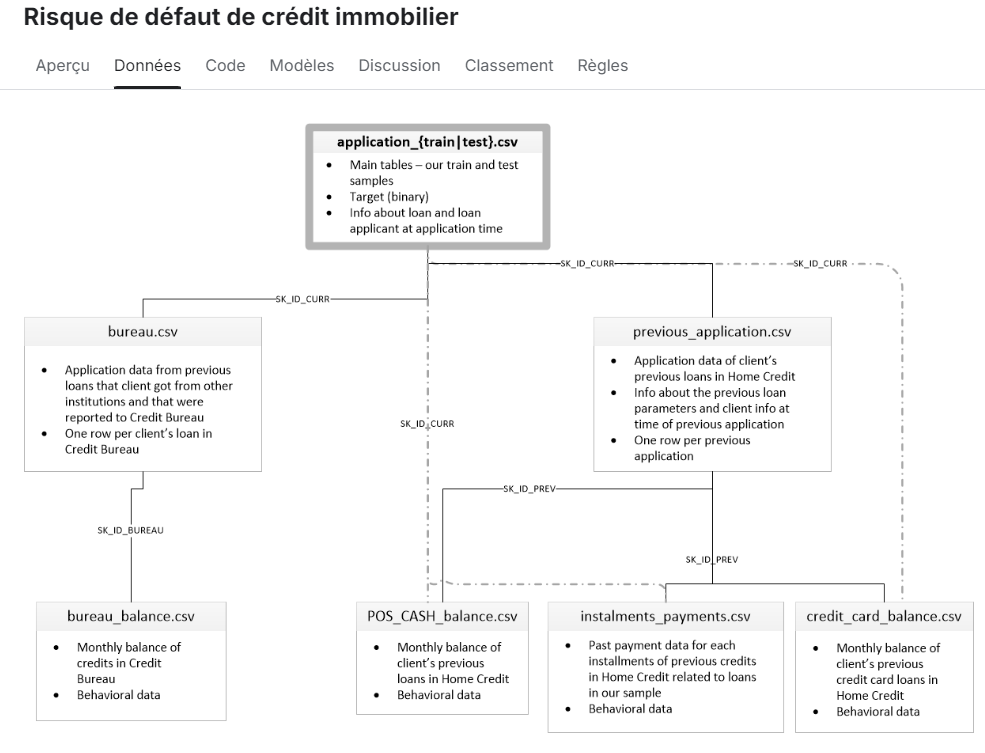

#Chargement du jeu de données

In [ ]:
!wget https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/Parcours_data_scientist/Projet+-+Impl%C3%A9menter+un+mod%C3%A8le+de+scoring/Projet+Mise+en+prod+-+home-credit-default-risk.zip


--2024-09-07 08:31:35--  https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/Parcours_data_scientist/Projet+-+Impl%C3%A9menter+un+mod%C3%A8le+de+scoring/Projet+Mise+en+prod+-+home-credit-default-risk.zip
Resolving s3-eu-west-1.amazonaws.com (s3-eu-west-1.amazonaws.com)... 52.218.97.202, 52.92.18.72, 52.92.0.200, ...
Connecting to s3-eu-west-1.amazonaws.com (s3-eu-west-1.amazonaws.com)|52.218.97.202|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 721615855 (688M) [application/zip]
Saving to: ‘Projet+Mise+en+prod+-+home-credit-default-risk.zip’

Projet+Mise+en+prod 100%[===================>] 688.19M  23.9MB/s    in 32s     

2024-09-07 08:32:08 (21.8 MB/s) - ‘Projet+Mise+en+prod+-+home-credit-default-risk.zip’ saved [721615855/721615855]



In [ ]:
!unzip Projet+Mise+en+prod+-+home-credit-default-risk.zip

Archive:  Projet+Mise+en+prod+-+home-credit-default-risk.zip
  inflating: installments_payments.csv  
  inflating: credit_card_balance.csv  
  inflating: bureau.csv              
  inflating: POS_CASH_balance.csv    
  inflating: sample_submission.csv   
  inflating: application_train.csv   
  inflating: HomeCredit_columns_description.csv  
  inflating: previous_application.csv  
  inflating: bureau_balance.csv      
  inflating: application_test.csv    


#Imports

In [ ]:

import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


#One-hot encoding

In [ ]:

# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

#application_train.csv et application_test.csv

In [ ]:
# Lecture des données d'entraînement et de test
df = pd.read_csv('application_train.csv')
test_df = pd.read_csv('application_test.csv')
print("Échantillons d'entraînement : {}, échantillons de test : {}".format(len(df), len(test_df)))

# Fusion des ensembles d'entraînement et de test
df = pd.concat([df, test_df]).reset_index(drop=True)

# Optionnel : suppression des 4 applications avec 'XNA' dans CODE_GENDER (jeu d'entraînement)
df = df[df['CODE_GENDER'] != 'XNA']

# Encodage binaire pour les fonctionnalités catégorielles avec deux catégories (0 ou 1)
for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
    df[bin_feature], uniques = pd.factorize(df[bin_feature])

# Encodage one-hot pour les fonctionnalités catégorielles restantes
df, cat_cols = one_hot_encoder(df, nan_as_category= False)

# Remplacement des valeurs NaN pour DAYS_EMPLOYED : 365.243 -> NaN (valeur anormale)
df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace=True)

# Création de nouvelles fonctionnalités simples (pourcentages)
df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']  # Pourcentage de jours employés par rapport aux jours de naissance
df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']  # Pourcentage de revenu total par rapport au crédit
df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']  # Revenu total par membre de la famille
df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']  # Pourcentage de revenu total par rapport à l'annuité
df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']  # Taux de paiement par rapport au crédit

# Suppression de l'ensemble de test pour libérer de la mémoire
del test_df
gc.collect()  # Nettoyage de la mémoire


Échantillons d'entraînement : 307511, échantillons de test : 48744


<ipython-input-5-8c0716faae38>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[bin_feature], uniques = pd.factorize(df[bin_feature])


0

#bureau.csv et bureau_balance.csv

In [ ]:
# Lecture des fichiers bureau.csv et bureau_balance.csv
bureau = pd.read_csv('bureau.csv')
bb = pd.read_csv('bureau_balance.csv')

# Encodage one-hot des variables catégorielles dans bureau_balance et bureau
bb, bb_cat = one_hot_encoder(bb, nan_as_category =True)
bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category=True)

# Agrégation des données dans bureau_balance
# Calcul des statistiques pour chaque SK_ID_BUREAU
bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
for col in bb_cat:
    bb_aggregations[col] = ['mean']

# Application des agrégations
bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
# Renommage des colonnes pour inclure les types d'agrégations
bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])

# Fusion des agrégations de bureau_balance avec bureau.csv
bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
# Suppression de la colonne SK_ID_BUREAU car elle n'est plus nécessaire
bureau.drop(['SK_ID_BUREAU'], axis=1, inplace=True)

# Libération de la mémoire
del bb, bb_agg
gc.collect()

# Agrégation des caractéristiques numériques
num_aggregations = {
    'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
    'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
    'DAYS_CREDIT_UPDATE': ['mean'],
    'CREDIT_DAY_OVERDUE': ['max', 'mean'],
    'AMT_CREDIT_MAX_OVERDUE': ['mean'],
    'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
    'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
    'AMT_CREDIT_SUM_OVERDUE': ['mean'],
    'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
    'AMT_ANNUITY': ['max', 'mean'],
    'CNT_CREDIT_PROLONG': ['sum'],
    'MONTHS_BALANCE_MIN': ['min'],
    'MONTHS_BALANCE_MAX': ['max'],
    'MONTHS_BALANCE_SIZE': ['mean', 'sum']
}

# Agrégation des caractéristiques catégorielles
cat_aggregations = {}
for cat in bureau_cat:
    cat_aggregations[cat] = ['mean']
for cat in bb_cat:
    cat_aggregations[cat + "_MEAN"] = ['mean']

# Agrégation des données dans bureau
bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
# Renommage des colonnes pour inclure les préfixes 'BURO_'
bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])

# Agrégation des crédits actifs
active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
# Renommage des colonnes pour inclure les préfixes 'ACTIVE_'
active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
# Fusion des agrégations des crédits actifs avec bureau_agg
bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')

# Libération de la mémoire
del active, active_agg
gc.collect()

# Agrégation des crédits fermés
closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
# Renommage des colonnes pour inclure les préfixes 'CLOSED_'
closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
# Fusion des agrégations des crédits fermés avec bureau_agg
bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')

# Libération de la mémoire
del closed, closed_agg, bureau
gc.collect()

0

#previous_applications.csv

In [ ]:
# Lecture du fichier previous_application.csv
prev = pd.read_csv('previous_application.csv')

# Encodage one-hot des variables catégorielles
prev, cat_cols = one_hot_encoder(prev, nan_as_category=True)

# Remplacement des valeurs 365.243 par NaN dans les colonnes de jours
prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace=True)
prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace=True)
prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace=True)
prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace=True)
prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace=True)

# Ajout d'une nouvelle caractéristique : pourcentage de la valeur demandée par rapport à la valeur reçue
prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']

# Agrégation des caractéristiques numériques
num_aggregations = {
    'AMT_ANNUITY': ['min', 'max', 'mean'],
    'AMT_APPLICATION': ['min', 'max', 'mean'],
    'AMT_CREDIT': ['min', 'max', 'mean'],
    'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
    'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
    'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
    'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
    'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
    'DAYS_DECISION': ['min', 'max', 'mean'],
    'CNT_PAYMENT': ['mean', 'sum'],
}

# Agrégation des caractéristiques catégorielles
cat_aggregations = {}
for cat in cat_cols:
    cat_aggregations[cat] = ['mean']

# Agrégation des données par SK_ID_CURR
prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
# Renommage des colonnes pour inclure le préfixe 'PREV_'
prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])

# Agrégation des applications approuvées : uniquement les caractéristiques numériques
approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
# Renommage des colonnes pour inclure le préfixe 'APPROVED_'
approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
# Fusion des agrégations des applications approuvées avec prev_agg
prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')

# Agrégation des applications refusées : uniquement les caractéristiques numériques
refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
# Renommage des colonnes pour inclure le préfixe 'REFUSED_'
refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
# Fusion des agrégations des applications refusées avec prev_agg
prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')

# Libération de la mémoire
del refused, refused_agg, approved, approved_agg, prev
gc.collect()

0

#POS_CASH_balance.csv

In [ ]:

# Lecture du fichier POS_CASH_balance.csv
pos = pd.read_csv('POS_CASH_balance.csv')

# Encodage one-hot des variables catégorielles
pos, cat_cols = one_hot_encoder(pos, nan_as_category=True)

# Définition des agrégations pour les caractéristiques numériques
aggregations = {
    'MONTHS_BALANCE': ['max', 'mean', 'size'],  # Maximum, moyenne, et taille pour la balance mensuelle
    'SK_DPD': ['max', 'mean'],                  # Maximum et moyenne pour SK_DPD
    'SK_DPD_DEF': ['max', 'mean']               # Maximum et moyenne pour SK_DPD_DEF
}

# Ajout des agrégations pour les caractéristiques catégorielles
for cat in cat_cols:
    aggregations[cat] = ['mean']

# Agrégation des données par SK_ID_CURR
pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)

# Renommage des colonnes pour inclure le préfixe 'POS_'
pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])

# Comptage du nombre de comptes POS_CASH pour chaque SK_ID_CURR
pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()

# Suppression du DataFrame original pour libérer de la mémoire
del pos

# Nettoyage de la mémoire
gc.collect()



0

#installments_payments.csv

In [ ]:
# Lecture du fichier installments_payments.csv
ins = pd.read_csv('installments_payments.csv')

# Encodage one-hot des variables catégorielles
ins, cat_cols = one_hot_encoder(ins, nan_as_category=True)

# Calcul du pourcentage payé et de la différence entre le montant payé et la valeur de l'échéance
ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']

# Calcul des jours passés depuis l'échéance (DPD) et des jours avant l'échéance (DBD)
# On s'assure que les valeurs négatives sont remplacées par 0
ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)

# Définition des agrégations pour les caractéristiques numériques
aggregations = {
    'NUM_INSTALMENT_VERSION': ['nunique'],          # Nombre d'installations uniques
    'DPD': ['max', 'mean', 'sum'],                   # Maximum, moyenne, somme pour DPD
    'DBD': ['max', 'mean', 'sum'],                   # Maximum, moyenne, somme pour DBD
    'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],   # Maximum, moyenne, somme, variance pour le pourcentage de paiement
    'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],   # Maximum, moyenne, somme, variance pour la différence de paiement
    'AMT_INSTALMENT': ['max', 'mean', 'sum'],        # Maximum, moyenne, somme pour le montant de l'échéance
    'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],    # Minimum, maximum, moyenne, somme pour le montant payé
    'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']     # Maximum, moyenne, somme pour les jours de paiement d'entrée
}

# Ajout des agrégations pour les caractéristiques catégorielles
for cat in cat_cols:
    aggregations[cat] = ['mean']

# Agrégation des données par SK_ID_CURR
ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)

# Renommage des colonnes pour inclure le préfixe 'INSTAL_'
ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])

# Comptage du nombre de comptes d'installations pour chaque SK_ID_CURR
ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()

# Suppression du DataFrame original pour libérer de la mémoire
del ins

# Nettoyage de la mémoire
gc.collect()

0

#credit_card_balance.csv

In [ ]:
# Chargement du fichier credit_card_balance.csv
cc = pd.read_csv('credit_card_balance.csv')

# Encodage one-hot des variables catégorielles
cc, cat_cols = one_hot_encoder(cc, nan_as_category=True)

# Suppression de la colonne 'SK_ID_PREV' qui n'est pas nécessaire pour l'agrégation
cc.drop(['SK_ID_PREV'], axis=1, inplace=True)

# Agrégation des données par 'SK_ID_CURR'
# Calcul des statistiques : minimum, maximum, moyenne, somme, variance
cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])

# Renommage des colonnes pour inclure le préfixe 'CC_'
cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])

# Comptage du nombre de lignes de crédit par 'SK_ID_CURR'
cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()

# Suppression du DataFrame d'origine pour libérer de la mémoire
del cc

# Nettoyage de la mémoire
gc.collect()

0

#Fusion

In [ ]:
# Fusionner les DataFrames en commençant par le DataFrame principal
# On suppose que vous travaillez sur le jeu de données d'entraînement ici

# Fusionner avec bureau_agg
df = df.merge(bureau_agg, how='left', on='SK_ID_CURR')

# Fusionner avec prev_agg
df = df.merge(prev_agg, how='left', on='SK_ID_CURR')

# Fusionner avec pos_agg
df = df.merge(pos_agg, how='left', on='SK_ID_CURR')

# Fusionner avec ins_agg
df = df.merge(ins_agg, how='left', on='SK_ID_CURR')

# Fusionner avec cc_agg
df = df.merge(cc_agg, how='left', on='SK_ID_CURR')

# À ce stade, df contient les données fusionnées de tous les fichiers
# Vous pouvez maintenant continuer avec le traitement ou l'analyse des données


# Vérification des valeurs infinies

Infinies positifs:

In [ ]:
print((df == np.inf).sum().sum())

61


Infinies négatifs:

In [ ]:
print((df == -np.inf).sum().sum())

0


In [ ]:
# Remplacer les valeurs infinies par NaN
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Pour vérifier que les valeurs infinies ont bien été remplacées
print((df == np.inf).sum().sum())  # Cela devrait afficher 0 après le remplacement

0


In [ ]:
df.shape

(356251, 797)

# Vérification des colonnes avec une seule valeur unique (dataframe entier)

In [ ]:
single_value_columns = [col for col in df.columns if df[col].nunique() == 1]

print(single_value_columns)
print(len(single_value_columns))

['BURO_CREDIT_ACTIVE_nan_MEAN', 'BURO_CREDIT_CURRENCY_nan_MEAN', 'BURO_CREDIT_TYPE_nan_MEAN', 'BURO_STATUS_nan_MEAN_MEAN', 'PREV_NAME_CONTRACT_TYPE_nan_MEAN', 'PREV_WEEKDAY_APPR_PROCESS_START_nan_MEAN', 'PREV_FLAG_LAST_APPL_PER_CONTRACT_nan_MEAN', 'PREV_NAME_CASH_LOAN_PURPOSE_nan_MEAN', 'PREV_NAME_CONTRACT_STATUS_nan_MEAN', 'PREV_NAME_PAYMENT_TYPE_nan_MEAN', 'PREV_CODE_REJECT_REASON_nan_MEAN', 'PREV_NAME_CLIENT_TYPE_nan_MEAN', 'PREV_NAME_GOODS_CATEGORY_nan_MEAN', 'PREV_NAME_PORTFOLIO_nan_MEAN', 'PREV_NAME_PRODUCT_TYPE_nan_MEAN', 'PREV_CHANNEL_TYPE_nan_MEAN', 'PREV_NAME_SELLER_INDUSTRY_nan_MEAN', 'PREV_NAME_YIELD_GROUP_nan_MEAN', 'POS_NAME_CONTRACT_STATUS_nan_MEAN', 'CC_NAME_CONTRACT_STATUS_Approved_MIN', 'CC_NAME_CONTRACT_STATUS_Refused_MIN', 'CC_NAME_CONTRACT_STATUS_Sent proposal_MIN', 'CC_NAME_CONTRACT_STATUS_nan_MIN', 'CC_NAME_CONTRACT_STATUS_nan_MAX', 'CC_NAME_CONTRACT_STATUS_nan_MEAN', 'CC_NAME_CONTRACT_STATUS_nan_SUM', 'CC_NAME_CONTRACT_STATUS_nan_VAR']
27


In [ ]:
df.drop(columns=single_value_columns, inplace=True)

In [ ]:
df.shape

(356251, 770)

# Exportation df en csv

In [ ]:
print(df.shape)
df.head()

(356251, 797)


,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR,CC_COUNT
0,100002,1.0,0,0,0,0,202500.0,406597.5,24700.5,351000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,100003,0.0,1,0,1,0,270000.0,1293502.5,35698.5,1129500.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,100004,0.0,0,1,0,0,67500.0,135000.0,6750.0,135000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100006,0.0,1,0,0,0,135000.0,312682.5,29686.5,297000.0,...,False,0.0,0.0,0.0,False,False,0.0,0.0,0.0,6.0
4,100007,0.0,0,0,0,0,121500.0,513000.0,21865.5,513000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df.to_csv('df.csv', index=False)

In [ ]:
import zipfile

# Créer un fichier zip
with zipfile.ZipFile('df.zip', 'w') as zipf:
    zipf.write('df.csv')

In [ ]:
from google.colab import files
files.download('df.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
df.to_csv('df_clean.csv', index=False)

#Chargement du fichier

In [ ]:
import pandas as pd

#le fichier CSV
df = pd.read_csv('df_clean.csv', sep = ',')

In [ ]:
df.shape

(356251, 770)

In [ ]:
df.head()

,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,CC_NAME_CONTRACT_STATUS_Sent proposal_MAX,CC_NAME_CONTRACT_STATUS_Sent proposal_MEAN,CC_NAME_CONTRACT_STATUS_Sent proposal_SUM,CC_NAME_CONTRACT_STATUS_Sent proposal_VAR,CC_NAME_CONTRACT_STATUS_Signed_MIN,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_COUNT
0,100002,1.0,0,0,0,0,202500.0,406597.5,24700.5,351000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,100003,0.0,1,0,1,0,270000.0,1293502.5,35698.5,1129500.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,100004,0.0,0,1,0,0,67500.0,135000.0,6750.0,135000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100006,0.0,1,0,0,0,135000.0,312682.5,29686.5,297000.0,...,False,0.0,0.0,0.0,False,False,0.0,0.0,0.0,6.0
4,100007,0.0,0,0,0,0,121500.0,513000.0,21865.5,513000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#Suppression des caractères spéciaux

In [ ]:
#df sans les caractères spéciaux dans les noms de colonnes

import re

#la fonction pour nettoyer les noms de colonnes
def clean_col_names(df):
    df.columns = [re.sub(r'\W+', '_', col) for col in df.columns]
    return df

#j'applique la fonction à df
df = clean_col_names(df)

#maintenant les colonnes ne contiennent plus de caractères spéciaux

In [ ]:
df.head()

,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,CC_NAME_CONTRACT_STATUS_Sent_proposal_MAX,CC_NAME_CONTRACT_STATUS_Sent_proposal_MEAN,CC_NAME_CONTRACT_STATUS_Sent_proposal_SUM,CC_NAME_CONTRACT_STATUS_Sent_proposal_VAR,CC_NAME_CONTRACT_STATUS_Signed_MIN,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_COUNT
0,100002,1.0,0,0,0,0,202500.0,406597.5,24700.5,351000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,100003,0.0,1,0,1,0,270000.0,1293502.5,35698.5,1129500.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,100004,0.0,0,1,0,0,67500.0,135000.0,6750.0,135000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100006,0.0,1,0,0,0,135000.0,312682.5,29686.5,297000.0,...,False,0.0,0.0,0.0,False,False,0.0,0.0,0.0,6.0
4,100007,0.0,0,0,0,0,121500.0,513000.0,21865.5,513000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#Les valeurs manquantes

In [ ]:
#le pourcentage des valeurs manquantes pour chaque colonne
valeur_m_p = df.isnull().mean() * 100

#les colonnes avec plus de 70% de valeurs manquantes
valeur_m_cols = valeur_m_p[valeur_m_p > 70].index

#le nombre de colonnes avec plus de 70% de valeurs manquantes
nb_valeur_m_cols = valeur_m_cols.shape[0]
print(f"Le nombre de colonnes avec plus de 70% de valeurs manquantes: {nb_valeur_m_cols}")

Le nombre de colonnes avec plus de 70% de valeurs manquantes: 144


In [ ]:
#le nombre de valeurs manquantes par colonne
missing_values = df.isnull().sum()
missing_values = missing_values[missing_values > 0]
print(missing_values)

TARGET                                  48744
AMT_ANNUITY                                36
AMT_GOODS_PRICE                           278
DAYS_EMPLOYED                           64648
OWN_CAR_AGE                            235239
                                        ...  
CC_NAME_CONTRACT_STATUS_Signed_MAX     252693
CC_NAME_CONTRACT_STATUS_Signed_MEAN    252693
CC_NAME_CONTRACT_STATUS_Signed_SUM     252693
CC_NAME_CONTRACT_STATUS_Signed_VAR     253385
CC_COUNT                               252693
Length: 590, dtype: int64


In [ ]:
#la suppression des colonnes avec plus de 70% de valeurs manquantes
df = df.drop(columns=valeur_m_cols)

print(f"Le nombre de colonnes restantes après suppression: {df.shape[1]}")
print(f"Le nombre de colonnes supprimées: {len(valeur_m_cols)}")

Le nombre de colonnes restantes après suppression: 626
Le nombre de colonnes supprimées: 144


In [ ]:
#le df à utiliser pour la classification binaire (la prédiction de deux catégorie: 0 ou 1 ): df_classification il contient des nan

#je ne garde que les donneées où la colonne 'TARGET' n'est pas vide.
# 'TARGET' est la variable à prédire (classification binaire), donc ces données sont nécessaires pour l'entraînement
df_classification_binaire = df[df['TARGET'].notnull()]
print(df_classification_binaire.shape)

(307507, 626)


In [ ]:
# Conversion des colonnes booléennes en numériques (0/1)
df_classification_binaire= df_classification_binaire.replace({False: 0, True: 1})
df_classification_binaire

C:\Users\HP\AppData\Local\Temp\ipykernel_11812\2708413751.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_classification_binaire= df_classification_binaire.replace({False: 0, True: 1})


,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,INSTAL_AMT_INSTALMENT_MEAN,INSTAL_AMT_INSTALMENT_SUM,INSTAL_AMT_PAYMENT_MIN,INSTAL_AMT_PAYMENT_MAX,INSTAL_AMT_PAYMENT_MEAN,INSTAL_AMT_PAYMENT_SUM,INSTAL_DAYS_ENTRY_PAYMENT_MAX,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,INSTAL_DAYS_ENTRY_PAYMENT_SUM,INSTAL_COUNT
0,100002,1.0,0,0,0,0,202500.0,406597.5,24700.5,351000.0,...,11559.247105,219625.695,9251.775,53093.745,11559.247105,219625.695,-49.0,-315.421053,-5993.0,19.0
1,100003,0.0,1,0,1,0,270000.0,1293502.5,35698.5,1129500.0,...,64754.586000,1618864.650,6662.970,560835.360,64754.586000,1618864.650,-544.0,-1385.320000,-34633.0,25.0
2,100004,0.0,0,1,0,0,67500.0,135000.0,6750.0,135000.0,...,7096.155000,21288.465,5357.250,10573.965,7096.155000,21288.465,-727.0,-761.666667,-2285.0,3.0
3,100006,0.0,1,0,0,0,135000.0,312682.5,29686.5,297000.0,...,62947.088438,1007153.415,2482.920,691786.890,62947.088438,1007153.415,-12.0,-271.625000,-4346.0,16.0
4,100007,0.0,0,0,0,0,121500.0,513000.0,21865.5,513000.0,...,12666.444545,835985.340,0.180,22678.785,12214.060227,806127.975,-14.0,-1032.242424,-68128.0,66.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307502,456251,0.0,0,0,1,0,157500.0,254700.0,27558.0,225000.0,...,7492.924286,52450.470,6605.910,12815.010,7492.924286,52450.470,-38.0,-156.285714,-1094.0,7.0
307503,456252,0.0,1,0,0,0,72000.0,269550.0,12001.5,225000.0,...,10069.867500,60419.205,10046.880,10074.465,10069.867500,60419.205,-2327.0,-2393.833333,-14363.0,6.0
307504,456253,0.0,1,0,0,0,153000.0,677664.0,29979.0,585000.0,...,4399.707857,61595.910,27.270,5575.185,4115.915357,57622.815,-1738.0,-2387.428571,-33424.0,14.0
307505,456254,1.0,1,0,0,0,171000.0,370107.0,20205.0,319500.0,...,10239.832895,194556.825,2296.440,19065.825,10239.832895,194556.825,-18.0,-161.263158,-3064.0,19.0


In [ ]:
df_classification_binaire.to_csv('df_classification_binaire.csv', index=False)

#Imputation

In [ ]:
#je remplace les valeurs manquantes par la MOYENNE des colonnes numériques
df = df_classification_binaire.copy()
df.fillna(df_classification_binaire.mean(), inplace=True)

In [ ]:
df.shape

(307507, 626)

In [ ]:
df.to_csv('df_clean_imputed.csv', index=False)